In [11]:
pip install pandas scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [12]:

import pandas as pd
import numpy as np

# Reproducibility
rng = np.random.default_rng(42)

n = 300
df = pd.DataFrame({
    "age": rng.integers(18, 70, size=n),
    "usage_gb": np.round(rng.normal(12, 6, size=n).clip(0, None), 1),
    "complaints": rng.integers(0, 6, size=n),
    "tenure_months": rng.integers(1, 60, size=n),
    "plan_type": rng.choice(["Prepaid", "Postpaid"], size=n, p=[0.6, 0.4])
})

# Simple churn signal (not perfect): high complaints + low tenure + low usage more likely to churn
logit = (
    -2.0
    + 0.35*df["complaints"]
    - 0.03*df["tenure_months"]
    - 0.04*df["usage_gb"]
    + (df["plan_type"] == "Prepaid").astype(int)*0.4
)
prob = 1/(1+np.exp(-logit))
df["churn"] = (rng.random(n) < prob).astype(int)

# Intentionally add a few missing/odd values to practice fixing (no row drops)
df.loc[rng.choice(df.index, 5, replace=False), "usage_gb"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "age"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "plan_type"] = None

df.to_csv("churn_data.csv", index=False)
print("Saved churn_data.csv with shape:", df.shape)
df.head()


Saved churn_data.csv with shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


In [14]:
import pandas as pd
from sklearn.impute import SimpleImputer

df = pd.read_csv("churn_data.csv")
print("Original shape:", df.shape)
display(df.head())

# --- Numeric imputation: fill NaNs with median (robust to outliers) ---
num_cols = ["age", "usage_gb", "complaints", "tenure_months"]
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# --- Categorical imputation: fill missing with most frequent ---
cat_cols = ["plan_type"]
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --- Encode plan_type to numeric (0=Prepaid, 1=Postpaid) ---
df["plan_type_enc"] = (df["plan_type"] == "Postpaid").astype(int)

# --- Feature matrix (X) and target (y) ---
X = df[["age", "usage_gb", "complaints", "tenure_months", "plan_type_enc"]]
y = df["churn"].astype(int)

print("Any remaining NaNs? ->", X.isna().sum().sum(), y.isna().sum())

# --- ✅ Save cleaned dataset to CSV ---
df.to_csv("updated_churn_data.csv", index=False)
print("✅ Saved cleaned dataset as 'updated_churn_data.csv' with", len(df), "rows.")



Original shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


Any remaining NaNs? -> 0 0
✅ Saved cleaned dataset as 'updated_churn_data.csv' with 300 rows.


In [15]:
import pandas as pd
from sklearn.impute import SimpleImputer

df = pd.read_csv("churn_data.csv")
print("Original shape:", df.shape)
display(df.head())

# --- Numeric imputation: fill NaNs with median (robust to outliers) ---
num_cols = ["age", "usage_gb", "complaints", "tenure_months"]
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# --- Categorical imputation: fill missing with most frequent ---
cat_cols = ["plan_type"]
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --- Encode plan_type to numeric (0=Prepaid, 1=Postpaid) ---
df["plan_type_enc"] = (df["plan_type"] == "Postpaid").astype(int)

# --- Feature matrix (X) and target (y) ---
X = df[["age", "usage_gb", "complaints", "tenure_months", "plan_type_enc"]]
y = df["churn"].astype(int)

print("Any remaining NaNs? ->", X.isna().sum().sum(), y.isna().sum())

# --- ✅ Save cleaned dataset to CSV ---
df.to_csv("updated_churn_data.csv", index=False)
print("✅ Saved cleaned dataset as 'updated_churn_data.csv' with", len(df), "rows.")


Original shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


Any remaining NaNs? -> 0 0
✅ Saved cleaned dataset as 'updated_churn_data.csv' with 300 rows.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train Decision Tree (simple baseline)
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# This is where the learning happens. The model looks at all the feature values in X_train and the correct answers in y_train, and learns patterns that connect them. After this step, the model can make predictions on unseen data.
print("Model trained.")


Model trained.


Accuracy: 75.56%

Classification report:
              precision    recall  f1-score   support

           0      0.850     0.872     0.861        78
           1      0.000     0.000     0.000        12

    accuracy                          0.756        90
   macro avg      0.425     0.436     0.430        90
weighted avg      0.737     0.756     0.746        90

Confusion matrix:
 [[68 10]
 [12  0]]


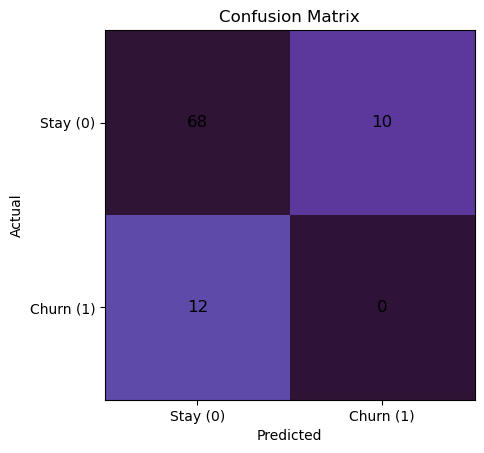

In [42]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")

# Detailed metrics
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Top-left (50) -> correctly predicted “Stay”
# Top-right (10) -> false alarms (predicted churn, actually stayed)
# Bottom-right (35) -> correctly predicted “Churn”
# Bottom-left (5) -> missed churns


# Plot nicely
fig, ax = plt.subplots()
ax.imshow(cm, cmap="twilight_shifted")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"]); ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


In [23]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5, random_state=42)


In [24]:
clf.fit(X_train, y_train)
print("✅ Decision Tree model trained.")


✅ Decision Tree model trained.


In [25]:
y_pred_dt = clf.predict(X_test)


In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {acc_dt:.2%}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_dt, digits=3))

cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion matrix:\n", cm_dt)


Decision Tree Accuracy: 75.56%

Classification report:
              precision    recall  f1-score   support

           0      0.850     0.872     0.861        78
           1      0.000     0.000     0.000        12

    accuracy                          0.756        90
   macro avg      0.425     0.436     0.430        90
weighted avg      0.737     0.756     0.746        90

Confusion matrix:
 [[68 10]
 [12  0]]


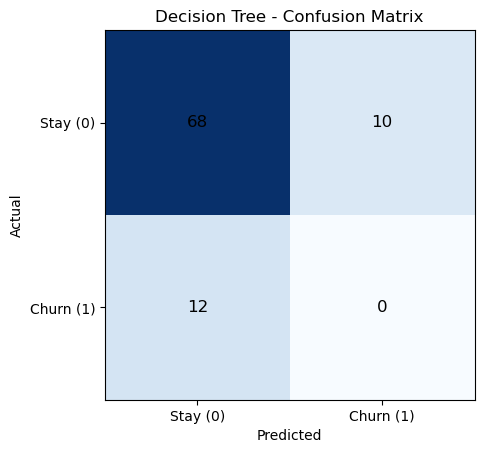

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.imshow(cm_dt, cmap="Blues")
ax.set_title("Decision Tree - Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

for (i, j), v in np.ndenumerate(cm_dt):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)

ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"])
ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,      # number of trees in the forest
    max_depth=5,           # limit tree depth to avoid overfitting
    random_state=42
)


In [29]:
rf.fit(X_train, y_train)
print("✅ Random Forest model trained.")


✅ Random Forest model trained.


In [30]:
y_pred_rf = rf.predict(X_test)


In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.2%}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_rf, digits=3))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion matrix:\n", cm_rf)


Random Forest Accuracy: 85.56%

Classification report:
              precision    recall  f1-score   support

           0      0.865     0.987     0.922        78
           1      0.000     0.000     0.000        12

    accuracy                          0.856        90
   macro avg      0.433     0.494     0.461        90
weighted avg      0.750     0.856     0.799        90

Confusion matrix:
 [[77  1]
 [12  0]]


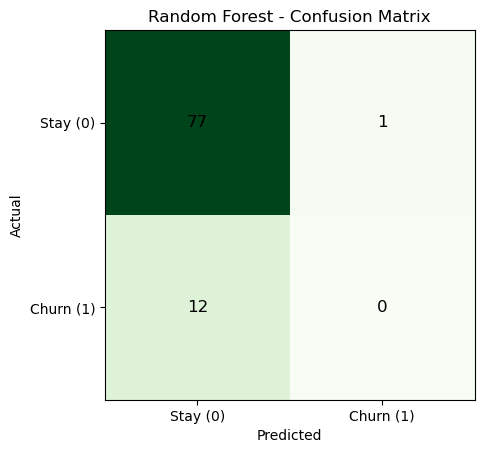

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.imshow(cm_rf, cmap="Greens")
ax.set_title("Random Forest - Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

for (i, j), v in np.ndenumerate(cm_rf):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)

ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"])
ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


In [33]:
from sklearn.svm import SVC

svm_clf = SVC(
    kernel="rbf",       # “rbf” works well for nonlinear data; use “linear” if data is simple
    C=1.0,              # regularization parameter (higher = less regularization)
    gamma="scale",      # controls how far influence of a point reaches
    probability=True,   # allows later probability-based metrics or plots
    random_state=42
)


In [34]:
svm_clf.fit(X_train, y_train)
print("✅ SVM model trained.")


✅ SVM model trained.


In [35]:
y_pred_svm = svm_clf.predict(X_test)


In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {acc_svm:.2%}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_svm, digits=3))

cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion matrix:\n", cm_svm)


SVM Accuracy: 86.67%

Classification report:
              precision    recall  f1-score   support

           0      0.867     1.000     0.929        78
           1      0.000     0.000     0.000        12

    accuracy                          0.867        90
   macro avg      0.433     0.500     0.464        90
weighted avg      0.751     0.867     0.805        90

Confusion matrix:
 [[78  0]
 [12  0]]


C:\Users\Priyanshi\OneDrive\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Priyanshi\OneDrive\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Priyanshi\OneDrive\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


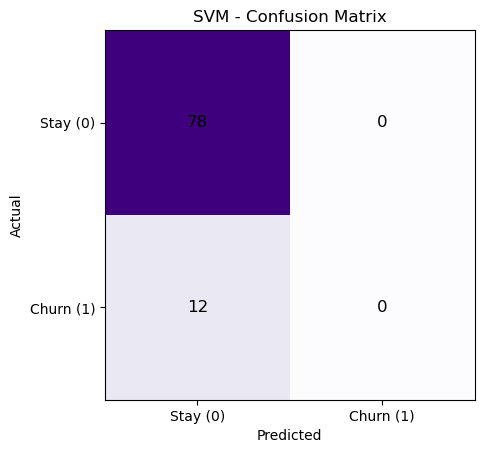

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.imshow(cm_svm, cmap="Purples")
ax.set_title("SVM - Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

for (i, j), v in np.ndenumerate(cm_svm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)

ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"])
ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


In [18]:
from sklearn.linear_model import LogisticRegression

# Create logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)


In [19]:
log_reg.fit(X_train, y_train)
print("✅ Logistic Regression model trained.")


✅ Logistic Regression model trained.


In [20]:
y_pred_lr = log_reg.predict(X_test)


In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {acc_lr:.2%}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_lr, digits=3))

cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion matrix:\n", cm_lr)


Logistic Regression Accuracy: 86.67%

Classification report:
              precision    recall  f1-score   support

           0      0.867     1.000     0.929        78
           1      0.000     0.000     0.000        12

    accuracy                          0.867        90
   macro avg      0.433     0.500     0.464        90
weighted avg      0.751     0.867     0.805        90

Confusion matrix:
 [[78  0]
 [12  0]]


C:\Users\Priyanshi\OneDrive\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Priyanshi\OneDrive\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Priyanshi\OneDrive\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


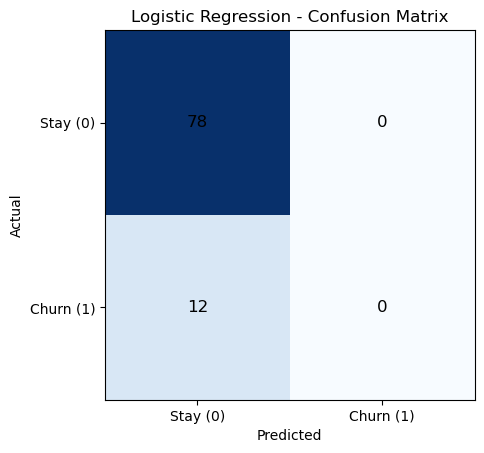

In [22]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.imshow(cm_lr, cmap="Blues")
ax.set_title("Logistic Regression - Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

for (i, j), v in np.ndenumerate(cm_lr):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)

ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"])
ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


In [10]:
import pandas as pd
import numpy as np

fi = pd.Series(best_clf.feature_importances_, index=X.columns) if 'best_clf' in globals() else pd.Series(clf.feature_importances_, index=X.columns)
print("Feature importance (higher = more influence):")
display(fi.sort_values(ascending=False).to_frame("importance"))



Feature importance (higher = more influence):


,importance
usage_gb,0.517355
tenure_months,0.227018
age,0.163932
complaints,0.091694
plan_type_enc,0.000000


In [11]:
import joblib
model_to_save = best_clf if 'best_clf' in globals() else clf
joblib.dump(model_to_save, "churn_decision_tree.joblib")
print("Saved churn_decision_tree.joblib")


Saved churn_decision_tree.joblib
